In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.svm import LinearSVC

In [2]:
df = pd.read_csv("iris.csv")
df

,x1,x2,class
0,4.1,1.3,c1
1,4.2,1.3,c1
2,4.3,1.3,c1
3,4.4,1.4,c1
4,4.5,1.6,c1
5,4.6,1.4,c1
6,4.7,1.2,c1
7,4.7,1.5,c1
8,4.8,1.4,c1
9,4.9,1.5,c1


In [3]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [4]:
# Question 1

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train_ori = X_train
X_test_ori = X_test
y_train_ori = y_train
y_test_ori = y_test

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

encoder = OneHotEncoder().fit(y.reshape(-1, 1))
y_train = encoder.transform(y_train.reshape(-1, 1))
y_test = encoder.transform(y_test.reshape(-1, 1))

In [6]:
X_train_df = pd.DataFrame(X_train, columns=["x1", "x2"])
y_train_df = pd.DataFrame(y_train_ori, columns=["class"])
train_df = pd.concat([X_train_df, y_train_df], axis=1)

In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    return x * (1 - x)

In [8]:
class NeuralNetwork: 
    def __init__(self, num_i, num_o, num_h, encoder):
        self.w1 = np.random.uniform(-1, 1, (num_i, num_h))
        self.w2 = np.random.uniform(-1, 1, (num_h, num_o))
        self.b1 = np.random.uniform(0, 1, (1, num_h))
        self.b2 = np.random.uniform(0, 1, (1, num_o))
        self.layer1 = np.zeros((num_i, num_h))
        self.layer2 = np.zeros((num_h, num_o))
        self.enc = encoder
        self.errors = []
                        
    def feedforward(self, x):
        self.layer1 = sigmoid(np.dot(x, self.w1) + self.b1)
        self.layer2 = sigmoid(np.dot(self.layer1, self.w2) + self.b2)
        
    def backpropogation(self, x, y, learning_rate):
        error_layer2 = (y - self.layer2) * sigmoid_deriv(self.layer2)
        error_layer1 = (error_layer2.dot(self.w2.T)) * sigmoid_deriv(self.layer1)
        self.w2 += self.layer1.T.dot(error_layer2) * learning_rate
        self.b2 += np.sum(error_layer2, axis=0, keepdims=True) * learning_rate
        self.w1 += x.T.dot(error_layer1) * learning_rate
        self.b1 += np.sum(error_layer1, axis=0, keepdims=True) * learning_rate
        return error_layer1.sum()
    
    def fit(self, x, y, learning_rate, epoch):
        for i in range(epoch):
            self.feedforward(x)
            self.errors.append(self.backpropogation(x, y, learning_rate))
            if i == 0: 
                print("w1 =", self.w1)
                print("w2 =", self.w2)

    def predict(self, x):
        layer1 = sigmoid(np.dot(x, self.w1) + self.b1)
        layer2 = sigmoid(np.dot(layer1, self.w2) + self.b2) 
        return encoder.inverse_transform(layer2)

In [9]:
def plot_learning_curve(clf, x=None, y=None):
    if x is not None and y is not None:
        train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(clf, x, y, n_jobs=10, return_times=True)
        plt.plot(train_sizes, np.mean(train_scores, axis=1))
    else: 
        plt.plot([1 - i for i in clf.errors])
    plt.title("Learning curve")
    plt.ylabel("Training error")
    plt.xlabel("Epoch")
    return plt

In [10]:
def plot_region_boundary(clf, x, df): 
    X = x
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.02), np.arange(x2_min, x2_max, 0.02))
    Z = clf.predict(np.c_[xx1.ravel(), xx2.ravel()])
    Zt = LabelEncoder().fit_transform(Z.reshape(-1,)).reshape(xx1.shape)
    
    sns.scatterplot(x="x1", y="x2", hue="class", data=df)
    plt.contourf(xx1, xx2, Zt, cmap="coolwarm", alpha=0.5)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    plt.title("Region boundary")
    return plt

In [11]:
def evaluate_performance(y_true, y_pred):
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred, target_names=["c1", "c2"], zero_division=1))

In [12]:
epoch = 10
learning_rate = 0.1
num_input_neurons = 2
num_output_neurons = 2
num_hidden_neurons = 3

mlp = NeuralNetwork(num_input_neurons, num_output_neurons, num_hidden_neurons, encoder)
mlp.fit(X_train, y_train.toarray(), learning_rate, epoch)

w1 = [[-0.49709351  0.59965395  0.40995468]
 [ 0.39518571 -0.51794646 -0.31068961]]
w2 = [[ 0.13660628 -0.4711338 ]
 [ 0.7453793  -0.02852218]
 [-0.23298283  0.7916238 ]]


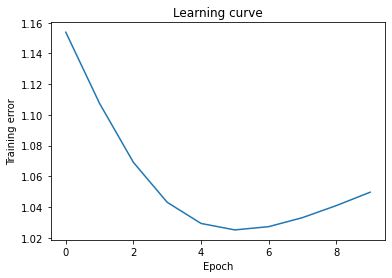

In [13]:
plt = plot_learning_curve(mlp)
plt.show()

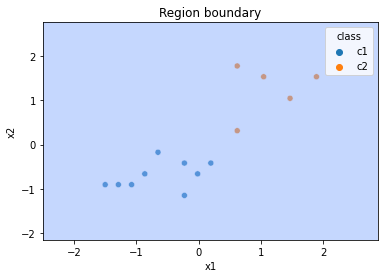

In [14]:
plt = plot_region_boundary(mlp, X_train, train_df)
plt.show()

In [15]:
evaluate_performance(encoder.inverse_transform(y_train), mlp.predict(X_train))

[[9 0]
 [5 0]]
              precision    recall  f1-score   support

          c1       0.64      1.00      0.78         9
          c2       1.00      0.00      0.00         5

    accuracy                           0.64        14
   macro avg       0.82      0.50      0.39        14
weighted avg       0.77      0.64      0.50        14



In [16]:
evaluate_performance(encoder.inverse_transform(y_test), mlp.predict(X_test))

[[1 0]
 [5 0]]
              precision    recall  f1-score   support

          c1       0.17      1.00      0.29         1
          c2       1.00      0.00      0.00         5

    accuracy                           0.17         6
   macro avg       0.58      0.50      0.14         6
weighted avg       0.86      0.17      0.05         6



In [17]:
# Question 2

In [18]:
svm = LinearSVC()
for i in range(10):
    svm.fit(X_train, y_train_ori)

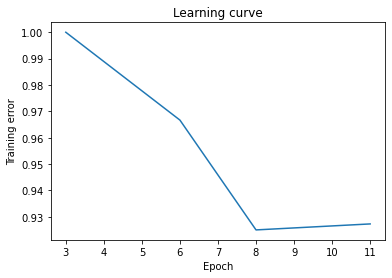

In [19]:
plt = plot_learning_curve(svm, X_train_ori, y_train_ori)
plt.show()

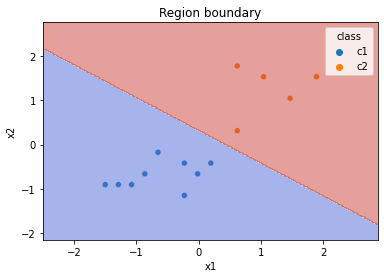

In [20]:
plt = plot_region_boundary(svm, X_train, train_df)
plt.show()

In [21]:
evaluate_performance(y_train_ori, svm.predict(X_train))

[[9 0]
 [0 5]]
              precision    recall  f1-score   support

          c1       1.00      1.00      1.00         9
          c2       1.00      1.00      1.00         5

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14



In [22]:
evaluate_performance(y_test_ori, svm.predict(X_test))

[[1 0]
 [2 3]]
              precision    recall  f1-score   support

          c1       0.33      1.00      0.50         1
          c2       1.00      0.60      0.75         5

    accuracy                           0.67         6
   macro avg       0.67      0.80      0.62         6
weighted avg       0.89      0.67      0.71         6



In [23]:
svm_sm = LinearSVC(C=50.0)
for i in range(10):
    svm_sm.fit(X_train, y_train_ori)

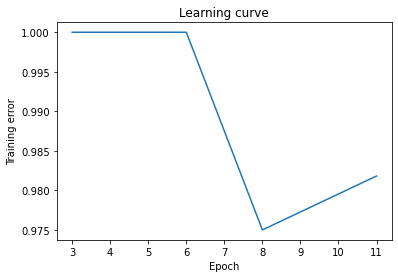

In [24]:
plt = plot_learning_curve(svm_sm, X_train_ori, y_train_ori)
plt.show()

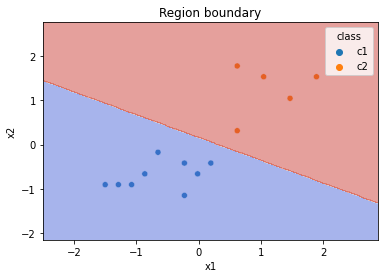

In [25]:
plt = plot_region_boundary(svm_sm, X_train, train_df)
plt.show()

In [26]:
evaluate_performance(y_train_ori, svm_sm.predict(X_train))

[[9 0]
 [0 5]]
              precision    recall  f1-score   support

          c1       1.00      1.00      1.00         9
          c2       1.00      1.00      1.00         5

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14



In [27]:
evaluate_performance(y_test_ori, svm_sm.predict(X_test))

[[1 0]
 [2 3]]
              precision    recall  f1-score   support

          c1       0.33      1.00      0.50         1
          c2       1.00      0.60      0.75         5

    accuracy                           0.67         6
   macro avg       0.67      0.80      0.62         6
weighted avg       0.89      0.67      0.71         6

